# 使用torch的resnet50模型  
## 1.resnet介绍  
ResNet (Residual Network) 是一种深度卷积神经网络，专门用于图像分类任务。  

### 1.1 resnet创新点  
```
传统网络: 输入 → 卷积 → 卷积 → ... → 输出
ResNet:     输入 → 卷积 → 卷积 → ... → 输出
                ↓         ↓
              +---------+                   
              | 残差连接 |
              +---------+
```  
传统神经网络随着层数加深，训练会变得困难（梯度消失/爆炸）。ResNet 引入了跳跃连接 (Skip Connection)：  

简单来说，就是把处理前的特征和残差相加，往后输出，可以避免特征丢失，从而可以大大增加深度，避免梯度消失  
当然，卷积和池化会改变原图的维度，因此有时需要对元数据进行扩大，保证对齐，如用1*1卷积核  

网络结构：
- 50层深度（包括卷积层、池化层等）
- 4个阶段 (Stage 1-4)，每阶段有多个残差块
- 瓶颈结构 (Bottleneck): 1×1 → 3×3 → 1×1 卷积  



## 1.2 resnet层数  
**resnet50层数**  
初始层: 1个卷积层 (conv1)
├── Stage 2: 3个残差块 × 每个块3个卷积层 = 9个卷积层  
├── Stage 3: 4个残差块 × 3个卷积层 = 12个卷积层
├── Stage 4: 6个残差块 × 3个卷积层 = 18个卷积层  
├── Stage 5: 3个残差块 × 3个卷积层 = 9个卷积层
└── 分类头: 1个全连接层  
总计50层  

标准ResNet层数 = 初始层 + 各Stage残差块的总卷积层 + 分类层  

但是50层不是精确的层数，只是卷积层和分类头的数量，BN,池化等操作没有考虑  

## 1.3 stage  
Stage = 一系列具有相同特征图尺寸的残差块的集合   

**在resnet50中，每层stage的详细配置为**     
Stage	特征图尺寸 通道数 残差块数量	下采样
Stage 1	224×224 → 56×56	64	-	stride=2 (conv+pool)
Stage 2	56×56	256	3	无
Stage 3	28×28	512	4	stride=2 (第一块)
Stage 4	14×14	1024	6	stride=2 (第一块)
Stage 5	7×7	2048	3	stride=2 (第一块)  

**尺寸**   
尺寸 = 特征图的空间维度 = [height, width]，单位: 像素 (pixel)  
大尺寸的信息更多，但是噪声也更多  

**通道**    
通道 = 特征图的深度维度 = 特征数量  

eg.  
每个通道可能学习不同类型的特征:  
- 通道 0: 检测垂直边缘  
- 通道 1: 检测水平边缘    
- 通道 2: 检测45度斜边  
- 通道 3: 检测纹理模式  
- 通道 4: 检测颜色对比  
- ... 一直到通道 2047

高层通道学习更抽象的特征:  
- 通道 1000: 检测"猫耳"模式
- 通道 1001: 检测"车轮"模式
- 通道 1002: 检测"文字"模式



In [2]:
"""
加载resnet50模型
"""
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# 使用字体管理器设置字体
import matplotlib
from matplotlib import font_manager
# 查找系统中可用的中文字体
fonts = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
chinese_fonts = [f for f in fonts if 'wenquan' in f.lower() or 'noto' in f.lower()]
print("可用的中文字体:", chinese_fonts)

# 设置matplotlib配置文件 (推荐)
matplotlib.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei', 'SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

model = resnet50(weights=ResNet50_Weights.DEFAULT)
model



可用的中文字体: ['/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc', '/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc', '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc', '/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc']


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 2.eval模式  
model.eval()设置模型为评估模式    

评估模式下，会禁用一些导致结果不同的特性（如dropout性质，导致差异）  
这样，就能保证数据训练结果每次都相同  


In [3]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 3.移动设备  

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"模型已加载到: {device}")
print(f"模型结构: {model}")

模型已加载到: cuda
模型结构: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=

## 4.图像变换处理   
**Resize**   
作用: 将任意大小的图像缩放到256×256像素  
确保所有图像有统一的大小，便于批处理  

示例:  
- 输入: 512×512图像 → 输出: 256×256图像  
- 输入: 100×200图像 → 输出: 256×256图像 (保持宽高比)  

**CentreCrop**   
作用: 从256×256图像中心裁剪出224×224区域  
ResNet50的标准输入尺寸是224×224   

裁剪过程:  
- 256×256图像中心 → 裁剪32像素边框 → 224×224图像  
- 裁剪宽度: (256-224)/2 = 16像素 (每侧8像素)  

**ToTensor**   
作用: 将PIL图像或numpy数组转换为PyTorch张量    
数据类型转换: PIL Image (0-255) → Tensor (0.0-1.0)    

数据格式变化:  
PIL Image: Height × Width × Channels (H×W×C)  
PyTorch Tensor: Channels × Height × Width (C×H×W)  

示例:
- 输入: PIL Image [224, 224, 3] (0-255)  
- 输出: Tensor [3, 224, 224] (0.0-1.0)  

**Normalize**    
作用: 对每个颜色通道进行标准化  
公式: output = (input - mean) / std  

ImageNet数据集的统计值:  
mean = [0.485, 0.456, 0.406]  # RGB通道的均值  
std = [0.229, 0.224, 0.225]   # RGB通道的标准差  

标准化过程:  
- Red通道:   (pixel - 0.485) / 0.229  
- Green通道: (pixel - 0.456) / 0.224      
- Blue通道:  (pixel - 0.406) / 0.225

In [5]:
# ImageNet预处理变换 (ResNet50的训练标准)
preprocess = transforms.Compose([
    transforms.Resize(256),                    # 缩放到256x256
    transforms.CenterCrop(224),                # 中心裁剪到224x224
    transforms.ToTensor(),                     # 转换为张量
    transforms.Normalize(                      # 标准化
        mean=[0.485, 0.456, 0.406],           # ImageNet均值
        std=[0.229, 0.224, 0.225]             # ImageNet标准差
    )
])

print("预处理变换已定义")

预处理变换已定义


## 5.推理测试  

数据将保存到: /home/frank/files/programs/AI引论第三次实验/data
正在下载 CIFAR-10 训练集...
Files already downloaded and verified
正在下载 CIFAR-10 测试集...
Files already downloaded and verified
创建数据加载器...
✅ 数据集下载完成！
训练集大小: 50000 张图片
测试集大小: 10000 张图片
类别数量: 10 个
类别列表: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei, SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei, SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei, SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei, SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei, SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei, SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei, SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei, SimHei


加载的图片形状: torch.Size([3, 32, 32])
图片标签: 3 (cat)


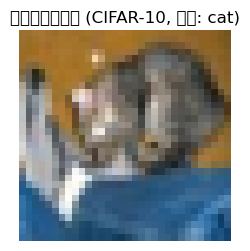

In [6]:
# 方法1: 使用DataLoader获取预处理后的数据
from src.load_data import load_cifar10_data
import numpy as np

# 加载数据 (batch_size=1用于获取单张图片)
train_loader, test_loader, classes = load_cifar10_data(batch_size=1)

# 获取第一张测试图片
test_iter = iter(test_loader)
images, labels = next(test_iter)
image_tensor = images[0]  # [3, 32, 32] 预处理后的张量
label = labels[0].item()  # 标签

print(f"加载的图片形状: {image_tensor.shape}")
print(f"图片标签: {label} ({classes[label]})")

# 如果需要显示图像，需要反标准化
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
mean = torch.tensor(stats[0]).view(3, 1, 1)
std = torch.tensor(stats[1]).view(3, 1, 1)

# 反标准化用于显示
display_image = image_tensor * std + mean
display_image = torch.clamp(display_image, 0, 1)
display_image = display_image.permute(1, 2, 0)  # [32, 32, 3] 用于imshow

# 显示图像
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(display_image.numpy())
plt.title(f"预处理后的图像 (CIFAR-10, 类别: {classes[label]})")
plt.axis('off')

# 预处理图像用于ResNet50推理 (需要调整到224x224)
resnet_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 将CIFAR-10格式转换为ImageNet格式
imagenet_tensor = resnet_preprocess(display_image.permute(2, 0, 1))  # [3, 224, 224]
input_tensor = imagenet_tensor.unsqueeze(0).to(device)

# 推理...